In [1]:
using DataFrames, CSV, LinearAlgebra
using Plots, StatsModels, StatsBase
using JuMP, Ipopt

In [5]:
function svm2(A, y; C=100)  # nonseparable data, but nonlinear constraint
    (m,n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0); # slack variables

    @objective(model, Min, sum(β[i]^2 for i in 1:n))

    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= 1-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)

    optimize!(model)
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    
    predicts = sign.(A * value.(β)) #part 2 section
    misclass_pts = sum(predicts .!= y)
    misclass_rate = misclass_pts / length(y)
    println("Misclassification rate = ", misclass_rate)
    
    return value.(β)
end

svm2 (generic function with 1 method)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1000
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.90e-01 1.75e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

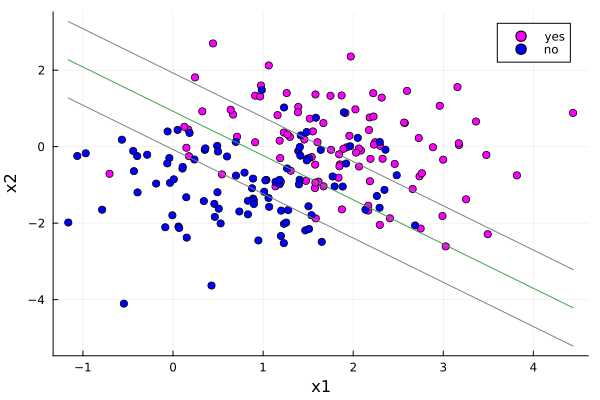

In [6]:
# two-class data
df = CSV.read("two-class-data.csv", DataFrame)

fo = @formula(y ~ 1 + x1 + x2)
A = modelmatrix(fo.rhs, df)
y = vec(modelmatrix(fo.lhs, df))

β = svm2(A, y; C=100)         # obtain the model parameters

f(x) = (-β[1] - β[2]*x)/β[3] # decision boundary helper function

yes = findall(x->x==1, y)    # indices for the +1 class
no  = findall(x->x==-1, y)   # indices for the -1 class

# plot the data
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes")
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")

# plot the decision boundary
plot!(df.x1, f.(df.x1), label="")

# plot the margins
plot!(df.x1, f.(df.x1) .+ 1, linecolor=:grey, label="")
plot!(df.x1, f.(df.x1) .- 1, linecolor=:grey, label="")

xlabel!("x1")
ylabel!("x2")

PART 3
The trade-off for using a very large C:
When you use a very large C, the misclassification rate for the training set will be quite small because it works to correctly classify the training data, even at the expense of the margin between the classes in the problem. The issue with this, and using a large C is that it can lead to overfitting for the model based on the data. Because of this overfitting, the performance on test data (data it has not seen before) will be sacrificed. Conversely, if you use a small value for C, the model will be much simpler, the margin between the classes will be higher, and the training error will be much higher than it would be with a larger C, but you avoid overfitting.